In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
from env import github_token, github_username

import prepare
import acquire
#import explore
#import model

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
from mergedeep import merge

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Acquire Data`
## Using  [Acquire.py](https://github.com/bert-jason-ray/nlp-group-project/blob/main/acquire.py) file to bring in new dataframe.`

In [2]:
# define the acquired file as new data frame
df = acquire.get_github_data()
df

,repo,language,readme_contents
0,jagrosh/MusicBot,Java,"<img align=""right"" src=""https://i.imgur.com/zr..."
1,Just-Some-Bots/MusicBot,Python,# MusicBot\n\n[![GitHub stars](https://img.shi...
2,SudhanPlayz/Discord-MusicBot,JavaScript,"<h1 align=""center""><img src=""./assets/logo.gif..."
3,IVETRI/SongPlayRoBot,Python,# Check Our New Bot Repo & Video :\n\n[Video](...
4,Splamy/TS3AudioBot,C#,# TS3AudioBot\n\nThis is a open-source TeamSpe...
...,...,...,...
195,Davidremo02/LazyMusicbot,NaN,"<h2 align=""centre"">Telegram Group Music Player..."
196,MrRizoel/RiZoeLXMusic,Python,"<h2 align=""centre"">ℝ𝚒ℤ𝚘𝚎𝕃𝕏𝕄𝚞𝚜𝚒𝚌 🎵</h2>\n\n### ..."
197,noirscape/MusicBot-2,Python,# Dynamic cog bot template\n\nThis is a bot te...
198,bhkvlldu/MusicBot,Python,# ⌯ Source zoro ˹♻️˼⁩\n\n• I am a developer in...


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Preapare Data`

## Using  [Prepare.py](https://github.com/bert-jason-ray/nlp-group-project/blob/main/prepare.py) to summon Clean, Stemmed, and Lemmatized data.

In [3]:
df = prepare.prep_github_data(df,column = 'readme_contents', extra_words=[], exclude_words=['musicbot'])
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,jagrosh/MusicBot,Java,"<img align=""right"" src=""https://i.imgur.com/zr...",img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...
1,Just-Some-Bots/MusicBot,Python,# MusicBot\n\n[![GitHub stars](https://img.shi...,music github starshttpsimgshieldsiogithubstars...,music github starshttpsimgshieldsiogithubstars...,music github starshttpsimgshieldsiogithubstars...
2,SudhanPlayz/Discord-MusicBot,JavaScript,"<h1 align=""center""><img src=""./assets/logo.gif...",h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...
3,IVETRI/SongPlayRoBot,Python,# Check Our New Bot Repo & Video :\n\n[Video](...,check new repo video videohttpsyoutube3pn0w4k...,check new repo video videohttpsyoutube3pn0w4kz...,check new repo video videohttpsyoutube3pn0w4kz...
5,galnir/Master-Bot,TypeScript,# A Discord Music Bot written in TypeScript Sa...,discord music written typescript sapphire dis...,discord music written typescript sapphir disco...,discord music written typescript sapphire disc...
...,...,...,...,...,...,...
192,Micium-Development/Bounce,JavaScript,### 📥 Micium-Development Is recruiting develop...,miciumdevelopment recruiting developers want j...,miciumdevelop recruit develop want join dev te...,miciumdevelopment recruiting developer want jo...
193,philliphqs/hqs.bot,Python,"<br />\n<p align=""center"">\n <a href=""https:/...",br p aligncenter hrefhttpsgithubcomphilliphqsh...,br p aligncent hrefhttpsgithubcomphilliphqshqs...,br p aligncenter hrefhttpsgithubcomphilliphqsh...
196,MrRizoel/RiZoeLXMusic,Python,"<h2 align=""centre"">ℝ𝚒ℤ𝚘𝚎𝕃𝕏𝕄𝚞𝚜𝚒𝚌 🎵</h2>\n\n### ...",h2 aligncentrerizoelxmusic h2 play music tele...,h2 aligncentrerizoelxmus h2 play music telegra...,h2 aligncentrerizoelxmusic h2 play music teleg...
197,noirscape/MusicBot-2,Python,# Dynamic cog bot template\n\nThis is a bot te...,dynamic cog template template discordpy fram...,dynam cog templat templat discordpi framework ...,dynamic cog template template discordpy framew...


## Looking at the amounts of times a specific language is used.

In [4]:
df = df.drop(columns = ['readme_contents', 'stemmed','clean'])

In [5]:
df = df.dropna()

In [6]:
df

,repo,language,lemmatized
0,jagrosh/MusicBot,Java,img alignright srchttpsiimgurcomzre80hypng hei...
1,Just-Some-Bots/MusicBot,Python,music github starshttpsimgshieldsiogithubstars...
2,SudhanPlayz/Discord-MusicBot,JavaScript,h1 aligncenterimg srcassetslogogif width30px d...
3,IVETRI/SongPlayRoBot,Python,check new repo video videohttpsyoutube3pn0w4kz...
5,galnir/Master-Bot,TypeScript,discord music written typescript sapphire disc...
...,...,...,...
192,Micium-Development/Bounce,JavaScript,miciumdevelopment recruiting developer want jo...
193,philliphqs/hqs.bot,Python,br p aligncenter hrefhttpsgithubcomphilliphqsh...
196,MrRizoel/RiZoeLXMusic,Python,h2 aligncentrerizoelxmusic h2 play music teleg...
197,noirscape/MusicBot-2,Python,dynamic cog template template discordpy framew...


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Splitting Data`

def split_github_data(df):
    '''
    This function performs split on github data, stratify language.
    Returns train, validate, and test dfs.
    '''
    train, test = train_test_split(df, test_size=.2, 
                                        random_state=123, stratify=df.language)
    #train, validate = train_test_split(train_validate, test_size=.3, 
                                   #random_state=123, stratify=train_validate.language)

    print('train--->', train.shape)
    #print('validate--->', validate.shape)
    print('test--->', test.shape)
    return train, test



In [7]:
train, test = prepare.split_github_data(df)

train---> (128, 3)
test---> (32, 3)


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `EXPLORE`

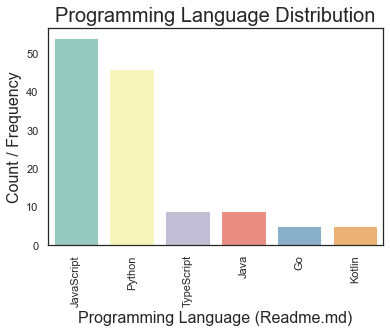

In [30]:
# Starting our exploration we quickly noticed a trend of a handful of programing languages dominating our data.
# As a result, we made the decision to focus on these main languages in an effort build a model more accurately discern between them
def programing_language_distribution():
    sns.set_theme(style="white")
    ax = sns.countplot(x="language", data=train, palette="Set3",order = train['language'].value_counts().index)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Programming Language (Readme.md)', size = 16)
    ax.set_ylabel('Count / Frequency', size = 16)
    ax.set_title("Programming Language Distribution", size = 20)
    plt.show()
programing_language_distribution()

### Takeaways:
 - **JavaScript & Python seem to dominate, while Java & TypeScript and all others seem to be at the 10 range.**

In [9]:
train.language.value_counts()

JavaScript    54
Python        46
TypeScript     9
Java           9
Go             5
Kotlin         5
Name: language, dtype: int64

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

## `Possible questions`**:**
- What are key words in all `READMEs`?
- Are there commom words in `READMEs` that all `programming languages` use?
- Do words in `READMEs` vary based on `programming languages` used?
- Do lenght of words vary in `READMEs` based on `programming languages`?

In [10]:
# Set up word counts dataframe
all_text = ' '.join(train.lemmatized)
javascript_text = ' '.join(train[train.language == 'JavaScript'].lemmatized)
python_text = ' '.join(train[train.language == 'Python'].lemmatized)
typescript_text = ' '.join(train[train.language == 'TypeScript'].lemmatized)
java_text = ' '.join(train[train.language == 'Java'].lemmatized)
go_text = ' '.join(train[train.language == 'Go'].lemmatized)
kotlin_text = ' '.join(train[train.language == 'Kotlin'].lemmatized)

In [33]:
def all_top_words():
    all_freq = pd.Series(str(all_text).split()).value_counts()
    javascript_freq = pd.Series(str(javascript_text).split()).value_counts()
    python_freq = pd.Series(str(python_text).split()).value_counts()
    typeScript_freq = pd.Series(str(typescript_text).split()).value_counts()
    java_freq = pd.Series(str(java_text).split()).value_counts()
    go_freq = pd.Series(str(go_text).split()).value_counts()
    kotlin_freq = pd.Series(str(kotlin_text).split()).value_counts()
    word_counts = pd.concat([all_freq, javascript_freq, python_freq, typeScript_freq,java_freq, go_freq, kotlin_freq], sort=True, axis=1)
    word_counts.columns = ['all', 'JavaScript', 'python', 'typescript','java', 'go', 'kotlin']
    word_counts = word_counts.fillna(0).apply(lambda s: s.astype(int))
    top_30 = word_counts.sort_values(by='all', ascending=False).head(30)
    return top_30
all_top_words()

,all,JavaScript,python,typescript,java,go,kotlin
music,476,88,319,21,21,17,10
song,216,60,116,10,10,8,12
command,175,60,59,20,14,11,11
play,175,50,87,7,3,19,9
discord,163,75,35,20,26,5,2
text,157,7,142,1,5,1,1
option,152,5,142,0,0,4,1
spotify,133,5,101,3,1,6,17
youtube,132,38,50,7,17,11,9
file,129,23,82,8,8,6,2


<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `What are key words in all READMEs & Are there commom words in READMEs that all programming languages use?`

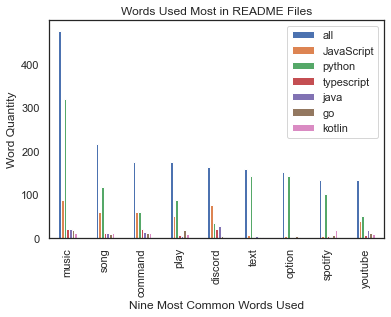

In [15]:
def word_distribution_vizual():
    # Visualize word distribution
    word_counts.sort_values(by='all', ascending=False)[['all','JavaScript', 'python', 'typescript','java', 'go', 'kotlin']].head(9).plot.bar()
    plt.title('Words Used Most in README Files')
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Nine Most Common Words Used')
    plt.ylabel('Word Quantity')
    plt.show()
word_distribution_vizual()

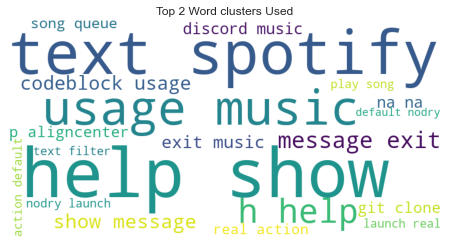

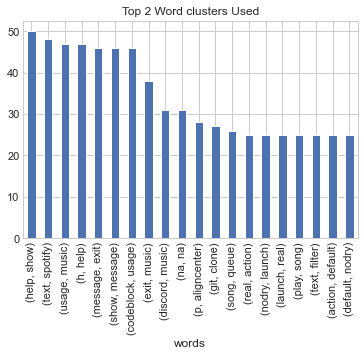

In [16]:
def all_words_bigram_wordcloud():
    all_D = pd.Series(str(all_text).split())
    top_20_all_words_bigrams = (pd.Series(nltk.ngrams(all_D, 2))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_words_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 2 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def all_words_bigram_barplot():
    all_D = pd.Series(str(all_text).split())
    top_20_all_words_bigrams = (pd.Series(nltk.ngrams(all_D, 2))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_all_words_bigrams.plot.bar()
    plt.title('Top 2 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
    
all_words_bigram_wordcloud()
all_words_bigram_barplot()

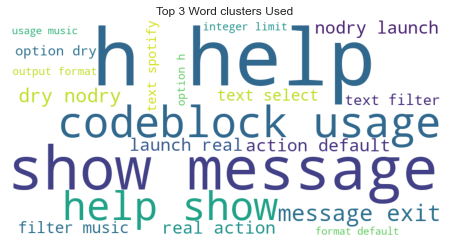

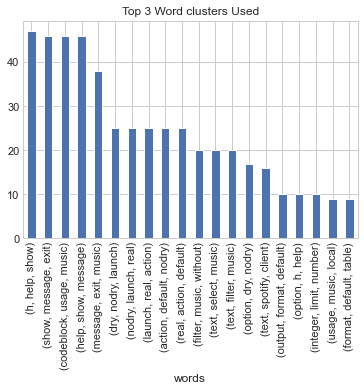

In [17]:
def all_words_trigram_wordcloud():
    all_D = pd.Series(str(all_text).split())
    top_20_all_words_trigrams = (pd.Series(nltk.ngrams(all_D, 3))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_words_trigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 3 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def all_words_trigram_barplot():
    all_D = pd.Series(str(all_text).split())
    top_20_all_words_trigrams = (pd.Series(nltk.ngrams(all_D, 3))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_all_words_trigrams.plot.bar()
    plt.title('Top 3 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
    
all_words_trigram_wordcloud()
all_words_trigram_barplot()

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Do words in READMEs vary based on programming languages used?`

**Python**

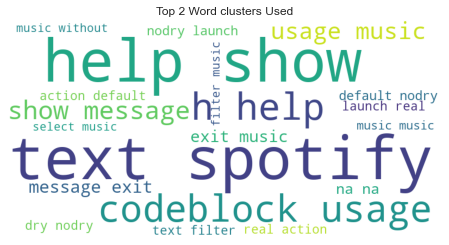

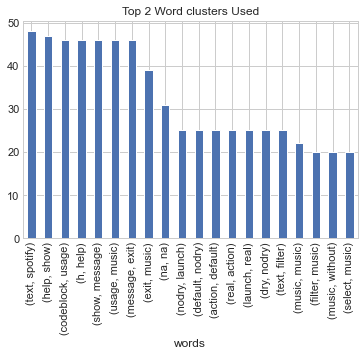

In [18]:
def python_bigram_wordcloud():
    python_D = pd.Series(str(python_text).split())
    top_20_python_bigrams = (pd.Series(nltk.ngrams(python_D, 2))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 2 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def python_bigram_barplot():
    python_D = pd.Series(str(python_text).split())
    top_20_python_bigrams = (pd.Series(nltk.ngrams(python_D, 2))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_python_bigrams.plot.bar()
    plt.title('Top 2 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
        
python_bigram_wordcloud()
python_bigram_barplot()

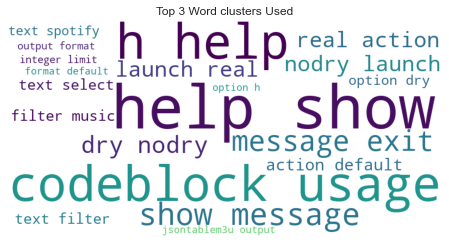

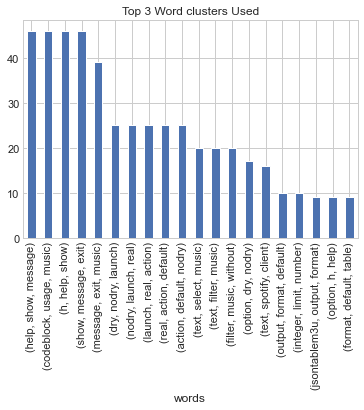

In [19]:
def python_trigram_wordcloud():
    python_D = pd.Series(str(python_text).split())
    top_20_python_trigrams = (pd.Series(nltk.ngrams(python_D, 3))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_trigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 3 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def python_trigram_barplot():
    python_D = pd.Series(str(python_text).split())
    top_20_python_trigrams = (pd.Series(nltk.ngrams(python_D, 3))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_python_trigrams.plot.bar()
    plt.title('Top 3 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
python_trigram_wordcloud()
python_trigram_barplot()

***
**JavaScript**
- Bigrams

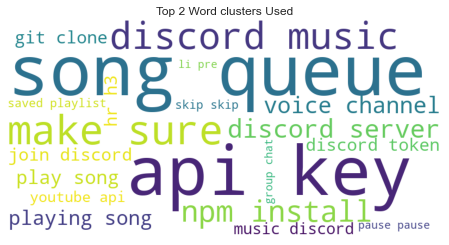

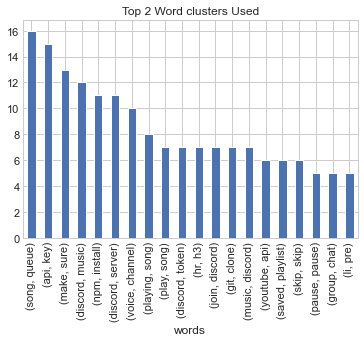

In [20]:
def javascript_bigram_wordcloud():
    javascript_D = pd.Series(str(javascript_text).split())
    top_20_javascript_bigrams = (pd.Series(nltk.ngrams(javascript_D, 2))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 2 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def javascript_bigram_barplot():
    javascript_D = pd.Series(str(javascript_text).split())
    top_20_javascript_bigrams = (pd.Series(nltk.ngrams(javascript_D, 2))
                          .value_counts()
                          .head(20))
    # Top 2 Words Used in README(s)
    top_20_javascript_bigrams.plot.bar()
    plt.title('Top 2 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
    
javascript_bigram_wordcloud()
javascript_bigram_barplot()

**JavaScript**
- trigrams

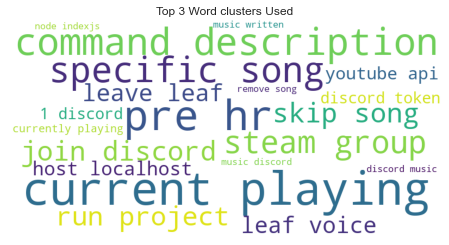

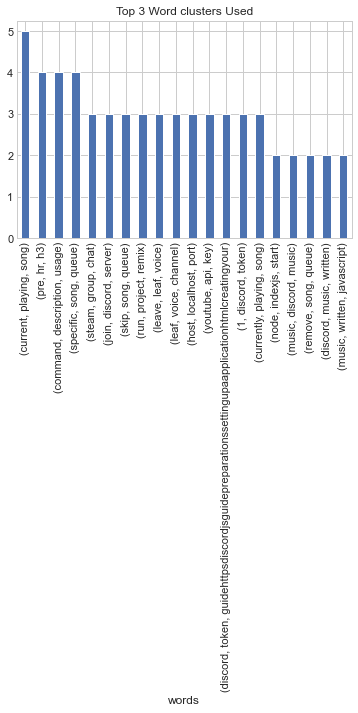

In [21]:
def javascript_trigram_wordcloud():
    javascript_D = pd.Series(str(javascript_text).split())
    top_20_javascript_trigrams = (pd.Series(nltk.ngrams(javascript_D, 3))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_trigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 3 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def javascript_trigram_barplot():
    javascript_D = pd.Series(str(javascript_text).split())
    top_20_javascript_trigrams = (pd.Series(nltk.ngrams(javascript_D, 3))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_javascript_trigrams.plot.bar()
    plt.title('Top 3 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()

javascript_trigram_wordcloud()
javascript_trigram_barplot()

***
**TypeScript**
- Bigrams

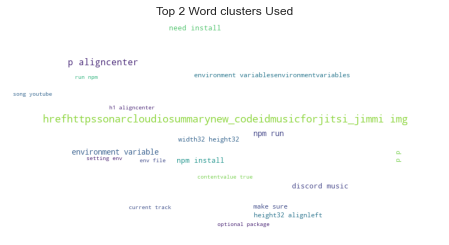

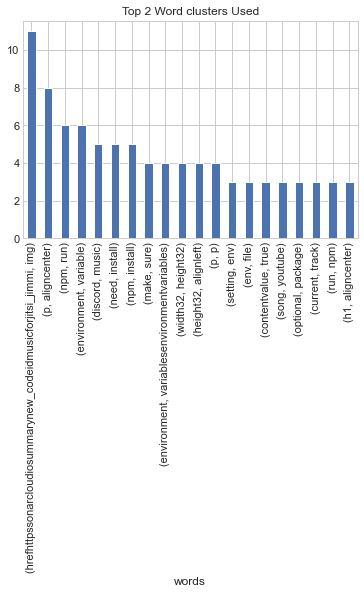

In [22]:
def typescript_bigram_wordcloud():
    typescript_D = pd.Series(str(typescript_text).split())
    top_20_typescript_bigrams = (pd.Series(nltk.ngrams(typescript_D, 2))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_typescript_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 2 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def typescript_bigram_barplot():
    typescript_D = pd.Series(str(typescript_text).split())
    top_20_typescript_bigrams = (pd.Series(nltk.ngrams(typescript_D, 2))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_typescript_bigrams.plot.bar()
    plt.title('Top 2 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()

typescript_bigram_wordcloud()
typescript_bigram_barplot()

**TypeScript**
- trigrams

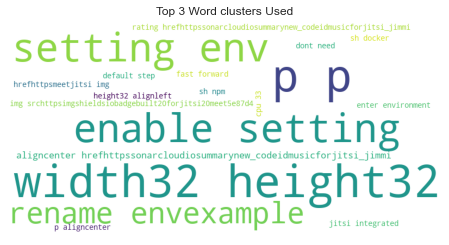

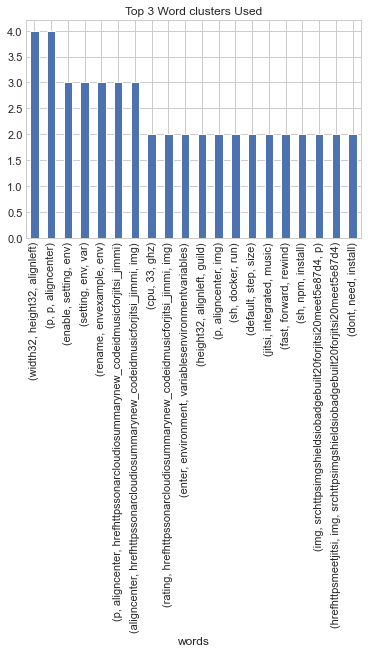

In [23]:
def typescript_trigram_wordcloud():
    typescript_D = pd.Series(str(typescript_text).split())
    top_20_typescript_trigrams = (pd.Series(nltk.ngrams(typescript_D, 3))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_typescript_trigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 3 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def typewscript_trigram_barplot():
    typescript_D = pd.Series(str(typescript_text).split())
    top_20_typescript_trigrams = (pd.Series(nltk.ngrams(typescript_D, 3))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_typescript_trigrams.plot.bar()
    plt.title('Top 3 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()

typescript_trigram_wordcloud()
typewscript_trigram_barplot()

***
**Java**
- Bigrams

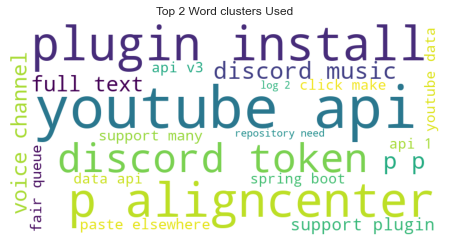

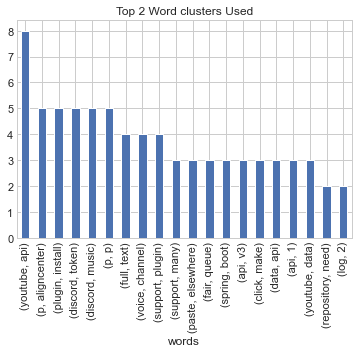

In [24]:
def java_bigram_wordcloud():
    java_D = pd.Series(str(java_text).split())
    top_20_java_bigrams = (pd.Series(nltk.ngrams(java_D, 2))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_java_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 2 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
def java_bigram_barplot():
    java_D = pd.Series(str(java_text).split())
    top_20_java_bigrams = (pd.Series(nltk.ngrams(java_D, 2))
                          .value_counts()
                          .head(20))
    # Top 2 Words Used in README(s)
    top_20_java_bigrams.plot.bar()
    plt.title('Top 2 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
java_bigram_wordcloud()
java_bigram_barplot()

**Java**
- Trigrams

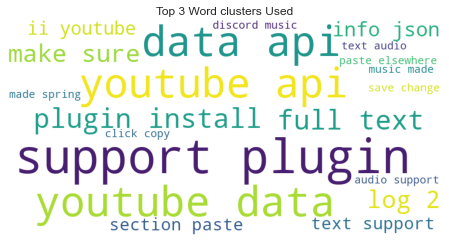

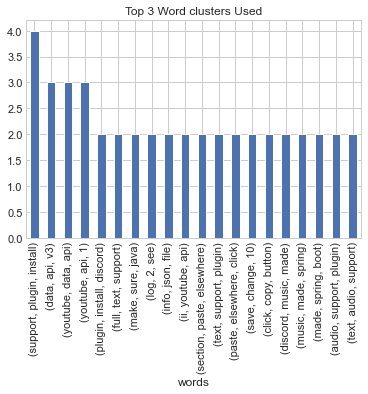

In [25]:
def java_trigram_wordcloud():
    java_D = pd.Series(str(java_text).split())
    top_20_java_trigrams = (pd.Series(nltk.ngrams(java_D, 3))
                                  .value_counts()
                                  .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_java_trigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 3 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
def java_trigram_barplot():
    java_D = pd.Series(str(java_text).split())
    top_20_java_trigrams = (pd.Series(nltk.ngrams(java_D, 3))
                                  .value_counts()
                                  .head(20))
    # Top 3 Words Used in README(s)
    top_20_java_trigrams.plot.bar()
    plt.title('Top 3 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
java_trigram_wordcloud()
java_trigram_barplot()    

***
**Go**
- Bigrams

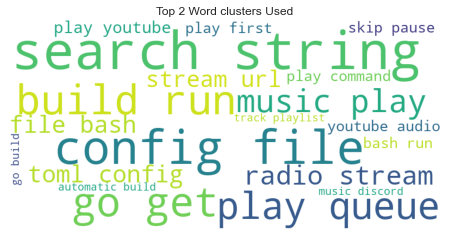

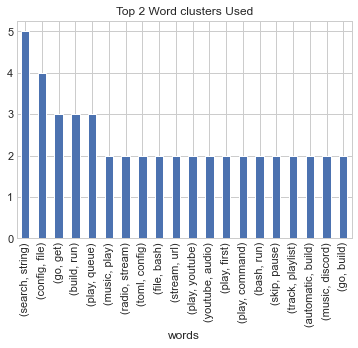

In [26]:
def go_bigram_wordcloud():
    go_D = pd.Series(str(go_text).split())
    top_20_go_bigrams = (pd.Series(nltk.ngrams(go_D, 2))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_go_bigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 2 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
def go_bigram_barplot():
    go_D = pd.Series(str(go_text).split())
    top_20_go_bigrams = (pd.Series(nltk.ngrams(go_D, 2))
                          .value_counts()
                          .head(20))
    # Top 2 Words Used in README(s)
    top_20_go_bigrams.plot.bar()
    plt.title('Top 2 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
    
go_bigram_wordcloud()
go_bigram_barplot()

**Go**
- Trigrams

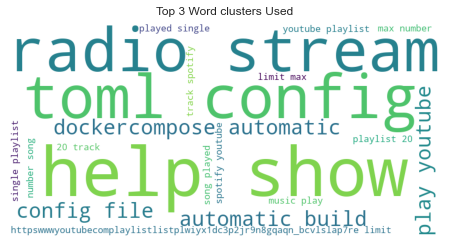

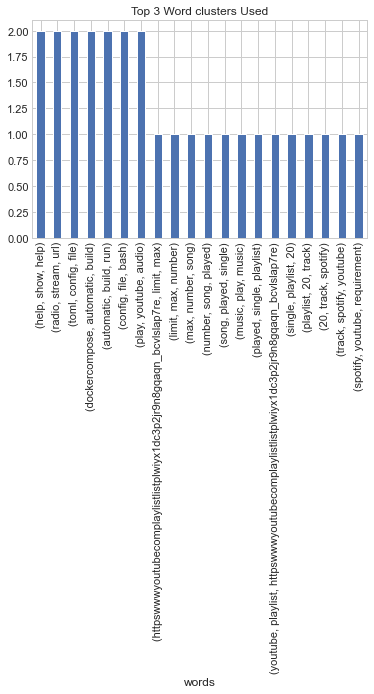

In [27]:
def go_trigram_wordcloud():
    go_D = pd.Series(str(go_text).split())
    top_20_go_trigrams = (pd.Series(nltk.ngrams(go_D, 3))
                          .value_counts()
                          .head(20))
    data = {k[0] + ' ' + k[1]: v for k, v in top_20_go_trigrams.to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
    plt.figure(figsize=(8, 4))
    plt.title('Top 3 Word clusters Used')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
def go_trigram_barplot():
    go_D = pd.Series(str(go_text).split())
    top_20_go_trigrams = (pd.Series(nltk.ngrams(go_D, 3))
                          .value_counts()
                          .head(20))
    # Top 3 Words Used in README(s)
    top_20_go_trigrams.plot.bar()
    plt.title('Top 3 Word clusters Used')
    plt.xlabel('words')
    plt.ylabel('')
    plt.show()
go_trigram_wordcloud()
go_trigram_barplot()

***
**UNIQUE VALUE COUNTS**

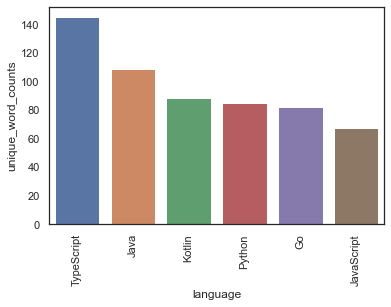

In [34]:
def unique_word_count():
    # Visual of the unique word counts
    train['unique_word_counts'] = train.lemmatized.apply(lambda x : len(set(x.split())))

    unique_train = pd.DataFrame(train.groupby('language').unique_word_counts.mean().sort_values(ascending=False)).reset_index()
    unique_train.head()

    ax = sns.barplot(x='language',y='unique_word_counts',data=unique_train)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()
unique_word_count()

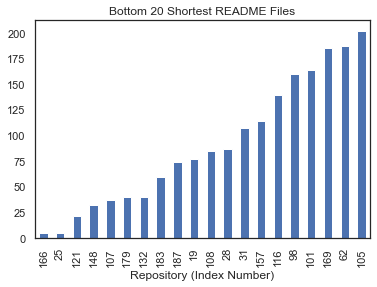

In [35]:
def min_words_in_read_mes():
    # min README(s)
    train.lemmatized.apply(len).sort_values().head(20).plot.bar(x=train.repo)
    plt.title('Bottom 20 Shortest README Files')
    plt.xlabel('Repository (Index Number)')
    plt.ylabel('')
    plt.show()
min_words_in_read_mes()

<hr style="border-top: 10px groove lightblue; margin-top: 1px; margin-bottom: 1px"></hr>

# `Do lenght of words vary in READMEs based on programming languages?`